In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
seed = 42

data = pd.read_csv('df_train.csv')

features = data.columns[:-1]
X, y = data[features].to_numpy(), data['type']

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [28]:
for k in np.unique(y):
    print((k, X[y==k].shape[0]))

(1, 49)
(2, 53)
(3, 12)
(5, 9)
(6, 6)
(7, 20)


In [4]:
def pca_reduced(X_train, X_val, pca_cutoff):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    cutoff_index = 0
    for i, s in enumerate(pca.explained_variance_ratio_):
        if s > pca_cutoff:
            cutoff_index = i
        else:
            break
    return X_train_pca[:, :cutoff_index], pca.transform(X_val)[:, :cutoff_index]

def train_val_score(clf, X_train, y_train, X_val, y_val):
    clf.fit(X_train, y_train)
    plot_confusion_matrix(clf, X_val, y_val, cmap=plt.cm.Blues)
    print(f'Training score: {clf.score(X_train, y_train)}')
    print(f'Validation score: {clf.score(X_val, y_val)}')

In [5]:
n_splits=5
pca_cutoff = 0.01

train_scores = []
val_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, val_index in kf.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index, :], X[val_index], y[train_index], y[val_index]

    X_train_pca_r, X_val_pca_r = pca_reduced(X_train, X_val, pca_cutoff)
    
    clf_knn = KNeighborsClassifier(n_neighbors=1)
    clf_knn.fit(X_train_pca_r, y_train)
    val_scores.append(clf_knn.score(X_val_pca_r, y_val))

print(np.mean(val_scores))


0.6917241379310346


# LDA M1

In [6]:
# np.cov(X_sc.T)

class LDAClf:
    def __init__(self,):
        self.Sw = None
        self.unique_classes = 0
        self.pi = {}
        self.mu = {}

    def fit(self, X, y):
        self.unique_classes = np.unique(y)
        self.Sw = np.zeros((X.shape[1],X.shape[1]))
        self.pi = {}
        self.mu = {}
        
        for k in self.unique_classes:
            X_k = X_sc[y==k, :]
            self.mu[k] = np.mean(X_k, axis=0)
            self.Sw = self.Sw + np.dot((X_k - self.mu[k]).T, (X_k - self.mu[k]))
            self.pi[k] = X_k.shape[0] / X_sc.shape[0]
        self.Sw = self.Sw/(X.shape[0] - len(self.unique_classes))
        
    def predict(self, X):
        preds=[]
        for i in range(X.shape[0]):
            best_score = None
            for k in self.unique_classes:
                score = self.discriminant(k, X[i, :])
                if best_score == None:
                    best_score = score
                    best_class = k
                elif score > best_score:
                    best_score = score
                    best_class = k
            preds.append(best_class)
        return np.array(preds)

    def discriminant(self, k, x):
        return 2 * np.log(self.pi[k]) - (x - self.mu[k]).T @ np.linalg.inv(self.Sw) @ (x - self.mu[k])

In [11]:
clf = LDAClf()
clf.fit(X_sc, y)
clf.predict(X_sc)-lda.predict(X_sc)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_sc, y)
lda.predict(X_sc)

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 7, 2, 2, 7, 3, 1, 2, 7, 2, 2, 1, 2, 7,
       7, 2, 1, 1, 6, 2, 6, 2, 2, 2, 6, 1, 1, 1, 2, 1, 1, 2, 7, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 2, 2, 7, 7, 3, 5, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 5, 1, 1, 6, 2, 2, 1, 6, 2, 2, 7, 1, 1, 1, 2, 5, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 6, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 7, 5, 7, 1,
       2, 1, 2, 1, 7, 1, 1, 2, 2, 2, 2, 2, 7, 1, 1, 7, 2, 1, 7, 7, 1, 1,
       7, 2, 1, 1, 2, 2, 5, 2, 5, 1, 2, 2, 1, 2, 7, 2, 2])

In [14]:
pipe = Pipeline(
    steps=[
        ('sc', StandardScaler()),
        ('pca', PCA()),
        ('lda', LinearDiscriminantAnalysis(store_covariance=True)),
    ]
)

param_grid = {
    #'pca__n_components': range(1,10),
    #'pca__n_components': [2],
    'lda__solver':['svd', 'lsqr', 'eigen'],
    'lda__n_components': range(1,6)
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Best score: 0.6245977011494253
{'lda__n_components': 1, 'lda__solver': 'svd'}


In [15]:
pipe = Pipeline(
    steps=[
        ('sc', StandardScaler()),
        ('pca', PCA()),
        ('qda', QuadraticDiscriminantAnalysis()),
    ]
)

param_grid = {
    #'pca__n_components': range(1,10),
    #'pca__n_components': [2],
    # 'lda__solver':['svd', 'lsqr', 'eigen'],
    # 'lda__n_components': range(1,6)
    'qda__reg_param': np.arange(0, 1, 0.1)
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Best score: 0.543448275862069
{'qda__reg_param': 0.8}


# Decision Tree M2

In [16]:
def gini_impurity(X1, X2, y1, y2):
    gini = 0.0
    n_obs = X1.shape[0] + X2.shape[0]
    for X, y in [(X1, y1), (X2, y2)]:
        n_obs_group = X.shape[0]

        if n_obs_group == 0:
            continue
        
        score = 0.0
        for k in np.unique(y):
            p = len(y.loc[y == k])/n_obs_group
            score += p * (1 - p)
        
        gini += (n_obs_group)/n_obs*score
    #print(gini)
    return gini

In [17]:
def partition(X, y, feature, cutoff):
    index1, index2 = np.where(X[:, feature] <= cutoff), np.where(X[:, feature] > cutoff)
    X1, X2 = X[index1], X[index2]
    y1, y2 = y.iloc[index1], y.iloc[index2]
    return X1, X2, y1, y2

In [18]:
def find_best_cut(X, y, min_samples_leaf=1):
    best_feature = None
    best_cutoff = None
    best_gini = None
    has_valid_cut = False
    for p in range(X.shape[1]):
        for cutoff in np.unique(X[:, p]):
            X1, X2, y1, y2 = partition(X, y, p, cutoff)
            if len(X1) < min_samples_leaf or len(X2) < min_samples_leaf:
                continue
            
            gini = gini_impurity(X1, X2, y1, y2)
            if (best_gini == None) or (gini < best_gini):
                has_valid_cut = True
                best_gini = gini
                best_feature = p
                best_cutoff = cutoff
    if has_valid_cut:
        X1, X2, y1, y2 = partition(X, y, best_feature, best_cutoff)
        best_cutoff = (np.min(X2[:, best_feature]) + best_cutoff)/2

    return best_feature, best_cutoff, best_gini    


In [19]:
find_best_cut(X, y)

(7, 0.4, 0.6199065196548418)

In [20]:
X1, X2, y1, y2 = partition(X, y, 0, X[0,0])
gini_impurity(X1, X2, y1, y2)

0.7299166158226561

In [21]:
class LeafNode:
    def __init__(self, y):
        self.y = y
        self.prediction_ = self._predict()
    
    def _predict(self):
        max_count = 0
        prediction = None
        for k in np.unique(self.y):
            count = len(self.y.loc[self.y==k])
            if (prediction == None) or count > max_count:
                max_count = count
                prediction = k
        return prediction

class InternalNode:
    def __init__(self, feature,  cutoff, true_child, false_child):
        self.feature = feature
        self.cutoff = cutoff
        self.true_child = true_child
        self.false_child = false_child

In [22]:
def _build_tree(X, y, max_depth=None, min_samples_leaf=1, min_samples_split=2, depth=0):
    current_gini = gini_impurity(X, X, y, y)/2
    # print(depth)
    if max_depth is not None:
        if depth == max_depth:
            return LeafNode(y)
    
    
    if current_gini == 0 or len(X) < min_samples_split:
        return LeafNode(y)

    feature, cutoff, best_gini = find_best_cut(X, y, min_samples_leaf)
    if best_gini is None:
        return LeafNode(y)

    X1, X2, y1, y2 = partition(X, y, feature, cutoff)

    true_child = _build_tree(
        X1, y1, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, depth=depth+1
    )
    false_child = _build_tree(
        X2, y2, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, depth=depth+1
    )
    return InternalNode(feature, cutoff, true_child, false_child)


def _print_tree(node, spacing='', extra_spacing='  '):
    if isinstance(node, LeafNode):
        print(f'{spacing}Predict: {node.prediction_}')
        return

    print(f'{spacing}X{node.feature} <= {node.cutoff}')
    print(f'{spacing}True:')
    _print_tree(node.true_child, spacing=spacing + extra_spacing)

    print(f'{spacing}False:')
    _print_tree(node.false_child, spacing=spacing + extra_spacing)


def _predict(tree, X):
        
        if isinstance(tree, LeafNode):
            return tree.prediction_
        if X[tree.feature] <= tree.cutoff:
            return _predict(tree.true_child, X)
        else:
            return _predict(tree.false_child, X)


class DecisionTreeClf:
    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2):
        self.tree = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
         
    def fit(self, X, y, depth=0):
        self.tree = _build_tree(
            X, y, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, min_samples_split=self.min_samples_split
        )

    def print_tree(self):
        _print_tree(self.tree)
        
    def predict(self, X):
        # if isinstance(self.tree, LeafNode):
        #     return self.tree.prediction_
        # if X[self.tree.feature] <= self.tree.cutoff:
        #     return predict(self.tree.true_child, X)
        # else:
        #     return predict(self.tree.false_child, X)
        preds = []
        for i in range(X.shape[0]):
            preds.append(_predict(self.tree, X[i,:]))
        return np.array(preds)

In [24]:
clf = DecisionTreeClf(max_depth=5, min_samples_split=8, min_samples_leaf=2)
clf.fit(X, y)
clf.print_tree()

X7 <= 0.4
True:
  X3 <= 1.42
  True:
    X6 <= 10.48
    True:
      X2 <= 3.865
      True:
        X0 <= 1.51707
        True:
          Predict: 3
        False:
          Predict: 1
      False:
        Predict: 2
    False:
      X0 <= 1.521325
      True:
        Predict: 5
      False:
        Predict: 2
  False:
    X2 <= 1.9849999999999999
    True:
      X1 <= 13.795
      True:
        Predict: 5
      False:
        Predict: 6
    False:
      X1 <= 12.835
      True:
        Predict: 1
      False:
        X6 <= 8.305
        True:
          Predict: 2
        False:
          Predict: 2
False:
  X4 <= 70.16
  True:
    Predict: 2
  False:
    X0 <= 1.519075
    True:
      Predict: 7
    False:
      Predict: 1


array([1, 2, 2, 2, 1, 2, 1, 5, 2, 7, 1, 2, 7, 1, 1, 1, 7, 1, 2, 1, 2, 7,
       7, 2, 3, 1, 6, 2, 6, 2, 1, 2, 3, 2, 7, 1, 2, 1, 1, 2, 7, 2, 1, 1,
       3, 1, 1, 2, 3, 2, 1, 3, 7, 7, 3, 5, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1,
       2, 2, 2, 1, 3, 5, 5, 2, 1, 6, 2, 2, 7, 1, 1, 1, 2, 5, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 3, 7, 2, 2, 1,
       2, 1, 1, 1, 7, 3, 1, 2, 5, 2, 1, 5, 7, 1, 1, 7, 2, 1, 7, 7, 1, 1,
       7, 1, 1, 3, 2, 2, 5, 2, 5, 1, 2, 2, 1, 2, 1, 1, 1])

In [26]:
clf_sk = DecisionTreeClassifier(max_depth=5, min_samples_split=8, min_samples_leaf=2)
clf_sk.fit(X, y)
clf.predict(X)-clf_sk.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print_tree(tree)

In [ ]:
pipe = Pipeline(
    steps=[
        #('sc', StandardScaler()),
        #('pca', PCA()),
        ('dtc', DecisionTreeClassifier()),
    ]
)

param_grid = {
    #'pca__n_components': range(1,10),
    #'pca__n_components': [2],
    'dtc__max_depth': range(1,10),
    'dtc__min_samples_leaf': range(1,5),
    'dtc__max_leaf_nodes': range(20,40)
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

# K-Nearest Neighbor M4

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

In [ ]:
pipe = Pipeline(
    steps=[
        ('sc', StandardScaler()),
        ('pca', PCA()),
        ('knn', KNeighborsClassifier()),
    ]
)

param_grid = {
    'pca__n_components': range(1,10),
    #'pca__n_components': [2],
    'knn__n_neighbors': range(1,10)
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Best score: 0.6781609195402298
{'knn__n_neighbors': 4, 'pca__n_components': 6}


# Support vector machine M3

In [ ]:
pipe = Pipeline(
    steps=[
        ('sc', StandardScaler()),
        # ('pca', PCA()),
        ('svc', SVC(random_state=seed)),
    ]
)

param_grid = {
    # 'pca__n_components': range(1, 10),
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': range(1, 5),
    'svc__C': np.arange(10, 20, 1),
    'svc__gamma': ['scale', 'auto'],
    'svc__class_weight': [None, 'balanced'],
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Best score: 0.6852873563218391
{'svc__C': 16, 'svc__class_weight': None, 'svc__degree': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


# Gradientboosting M5

In [49]:
pipe = Pipeline(
    steps=[
        ('sc', StandardScaler()),
        ('pca', PCA()),
        ('gdb', GradientBoostingClassifier(random_state=seed)),
    ]
)

param_grid = {
    'pca__n_components': range(4, 10),
    # 'gdb__loss': ['deviance', 'exponential'],
    'gdb__learning_rate': np.arange(0.1,0.2,0.01),
    'gdb__n_estimators':range(10,100,10),
     'gdb__min_samples_leaf': range(1,5),
    # 'gdb__max_depth': range(1,10),
    'gdb__max_depth': range(3,5),
    'gdb__max_leaf_nodes': range(20,60,2)
}

# search = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
search = RandomizedSearchCV(pipe, param_grid, cv=5, verbose=2, random_state=seed)
search.fit(X_sc, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] pca__n_components=7, gdb__n_estimators=50, gdb__min_samples_leaf=1, gdb__max_leaf_nodes=46, gdb__max_depth=4, gdb__learning_rate=0.11 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  pca__n_components=7, gdb__n_estimators=50, gdb__min_samples_leaf=1, gdb__max_leaf_nodes=46, gdb__max_depth=4, gdb__learning_rate=0.11, total=   0.3s
[CV] pca__n_components=7, gdb__n_estimators=50, gdb__min_samples_leaf=1, gdb__max_leaf_nodes=46, gdb__max_depth=4, gdb__learning_rate=0.11 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV]  pca__n_components=7, gdb__n_estimators=50, gdb__min_samples_leaf=1, gdb__max_leaf_nodes=46, gdb__max_depth=4, gdb__learning_rate=0.11, total=   0.3s
[CV] pca__n_components=7, gdb__n_estimators=50, gdb__min_samples_leaf=1, gdb__max_leaf_nodes=46, gdb__max_depth=4, gdb__learning_rate=0.11 
[CV]  pca__n_components=7, gdb__n_estimators=50,

In [44]:
np.arange(0.01,0.2,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

In [ ]:
pipe = Pipeline(
    steps=[
        #('sc', StandardScaler()),
        #('pca', PCA()),
        ('gdb', GradientBoostingClassifier(random_state=seed)),
    ]
)

param_grid = {
    #'pca__n_components': range(4, 10),
    # 'gdb__loss': ['deviance', 'exponential'],
    #'gdb__learning_rate': np.arange(0.01,0.2,0.01),
    # 'gdb__n_estimators':range(10,100,10),
     'gdb__min_samples_leaf': range(1,5),
    'gdb__max_depth': range(1,4),
    #'gdb__max_leaf_nodes': range(20,60,2)
}

search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(X, y)
print(f'Best score: {search.best_score_}')
print(search.best_params_)

Best score: 0.7517241379310345
{'gdb__max_depth': 3, 'gdb__min_samples_leaf': 2}


array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>,
        <AxesSubplot:xlabel='5', ylabel='0'>,
        <AxesSubplot:xlabel='6', ylabel='0'>,
        <AxesSubplot:xlabel='7', ylabel='0'>,
        <AxesSubplot:xlabel='8', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>,
        <AxesSubplot:xlabel='5', ylabel='1'>,
        <AxesSubplot:xlabel='6', ylabel='1'>,
        <AxesSubplot:xlabel='7', ylabel='1'>,
        <AxesSubplot:xlabel='8', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3',

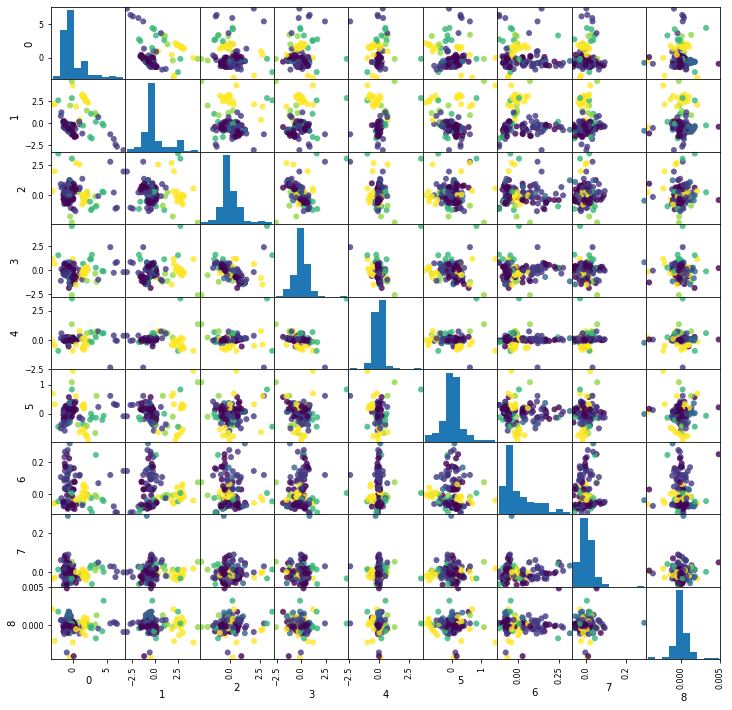

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)
pd.plotting.scatter_matrix(pd.DataFrame(X_pca), c=y, figsize=(12,12), marker='o', alpha=.8)

array([0.483, 0.272, 0.106, 0.089, 0.032, 0.016, 0.001, 0.   , 0.   ])

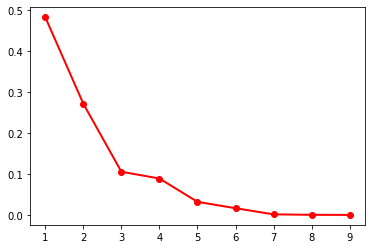

In [ ]:
plt.plot(range(1,10), pca.explained_variance_ratio_, 'ro-', linewidth=2)
np.round(pca.explained_variance_ratio_,3)

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>,
        <AxesSubplot:xlabel='4', ylabel='3'>],
       [<AxesSubplot:xlabel='0', ylabel='4'>,
        <AxesSubplot:xlabel='1

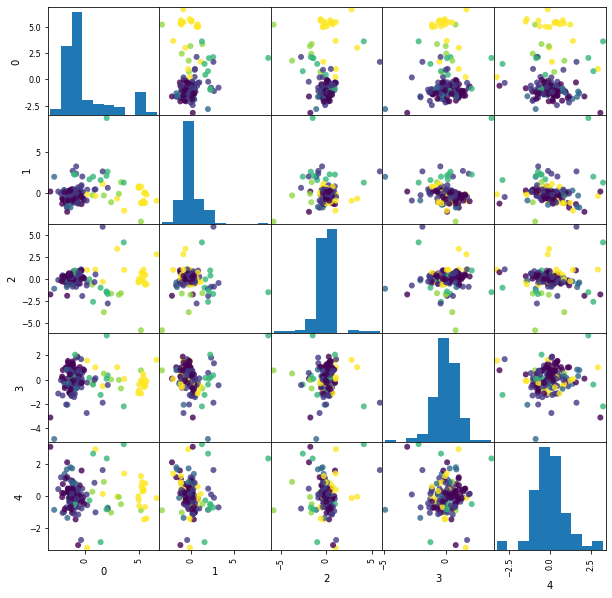

In [ ]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_sc, y)
pd.plotting.scatter_matrix(pd.DataFrame(X_lda), c=y, figsize=(10,10), marker='o', alpha=.8)

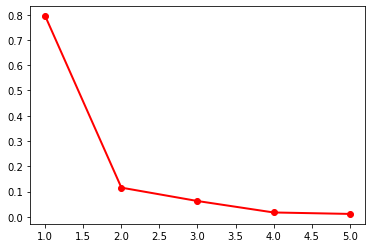

In [ ]:
plt.plot(range(1,6), lda.explained_variance_ratio_, 'ro-', linewidth=2)

In [ ]:
X_train_pca_r = X_train_pca[:, :5]
X_val_pca = pca.transform(X_val)
X_val_pca_r = X_val_pca[:, :5]

NameError: name 'X_train_pca' is not defined

0.41379310344827586


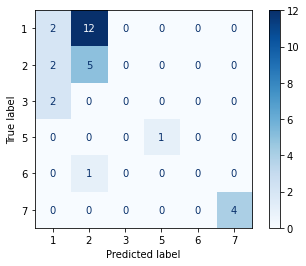

In [ ]:
clf_svc = SVC(random_state=seed, kernel='rbf')
clf_svc.fit(X_train_pca_r, y_train)
plot_confusion_matrix(clf_svc, X_val_pca_r, y_val, cmap=plt.cm.Blues)
print(clf_svc.score(X_val_pca_r, y_val))

In [ ]:
X_train_pca_2 = X_train_pca[:, :2]
X_val_pca_2 = pca.transform(X_val)[:, :2]
clf_knn = KNeighborsClassifier(n_neighbors=4)
clf_knn.fit(X_train_pca_2, y_train)
plot_confusion_matrix(clf_knn, X_val_pca_2, y_val, cmap=plt.cm.Blues)
print(clf_knn.score(X_val_pca_2, y_val))


NameError: name 'X_train_pca' is not defined

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)

In [ ]:
xx, yy = make_meshgrid(X_train_pca_2[:, 0], X_train_pca_2[:, 1])
fig, ax = plt.subplots()
plot_contours(ax, clf_knn, xx, yy, alpha=0.8)
ax.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=y_train, s=20)

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
np.round(lda.explained_variance_ratio_, 3)
X_val_lda = lda.transform(X_val)

In [ ]:
X_train_lda_2 = X_train_lda[:, :2]
X_val_lda_2 = lda.transform(X_val)[:, :2]
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_lda_2, y_train)
plot_confusion_matrix(clf_knn, X_val_lda_2, y_val, cmap=plt.cm.Blues)
print(clf_knn.score(X_val_lda_2, y_val))

In [ ]:
xx, yy = make_meshgrid(X_train_lda_2[:, 0], X_train_lda_2[:, 1])
fig, ax = plt.subplots()
plot_contours(ax, clf_knn, xx, yy, alpha=0.8)
ax.scatter(X_train_lda_2[:, 0], X_train_lda_2[:, 1], c=y_train, s=20)

In [ ]:
plot_confusion_matrix(lda, X_val, y_val, cmap=plt.cm.Blues)
print(lda.score(X_val, y_val))

In [ ]:
lda.fit(X_train_pca_r, y_train)

X_train_pca_lda_2 = lda.transform(X_train_pca_r)[:, :2]
X_val_pca_lda_2 = lda.transform(X_val_pca_r)[:, :2]

clf_knn = KNeighborsClassifier(n_neighbors=4)
clf_knn.fit(X_train_pca_lda_2, y_train)

plot_confusion_matrix(clf_knn, X_val_pca_lda_2, y_val, cmap=plt.cm.Blues)
print(clf_knn.score(X_val_pca_lda_2, y_val))

In [ ]:
X_train_pca_lda = lda.transform(X_train_pca_r)
X_val_pca_lda = lda.transform(X_val_pca_r)

clf_svc = SVC(random_state=seed, kernel='linear')
clf_svc.fit(X_train_pca_lda, y_train)
plot_confusion_matrix(clf_svc, X_val_pca_lda, y_val, cmap=plt.cm.Blues)
print(clf_svc.score(X_val_pca_lda, y_val))

In [ ]:
clf_qda = QuadraticDiscriminantAnalysis()
clf_qda.fit(X_train_pca_r, y_train)
plot_confusion_matrix(clf_qda, X_val_pca_r, y_val, cmap=plt.cm.Blues)
print(clf_qda.score(X_val_pca_r, y_val))

In [ ]:
train_test_score(QuadraticDiscriminantAnalysis(), X_train_pca_lda, y_train, X_val_pca_lda, y_val)

In [ ]:
train_test_score(LinearDiscriminantAnalysis(), X_train_pca_r, y_train, X_val_pca_r, y_val)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
train_test_score(
    DecisionTreeClassifier(max_depth=5 ),
    X_train_pca_lda,
    y_train,
    X_val_pca_lda,
    y_val
)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
train_test_score(
    GradientBoostingClassifier(random_state=seed, max_depth=3),
    X_train_lda,
    y_train,
    X_val_lda,
    y_val
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
train_test_score(
    RandomForestClassifier(random_state=seed, max_depth=4),
    X_train_pca,
    y_train,
    X_val_pca,
    y_val
)

In [ ]:
# #Opgave 1

# x_c1= X_train[y_train==0,:]
# x_c2= X_train[y_train==1,:]
# x_c3= X_train[y_train==2,:]

# print("\n ", np.cov(x_c1[:,0],x_c1[:,1]))

# print("\n ", np.cov(x_c2[:,0],x_c2[:,1]))

# print("\n ", np.cov(x_c3[:,0],x_c3[:,1]))

#for i, k in enumerate(np.unique(y)):
#    print(f'Type: {k}, Index: {i}'

In [ ]:
cov_matrices = {}
for k in np.unique(y):
    cov_matrices[k] = np.round(np.cov(X_train[y_train == k].T), 2)
    print(cov_matrices[k])
# print(cov_matrices)